(np.float64(1128.6979622577605), np.float64(3270768.8974873824))

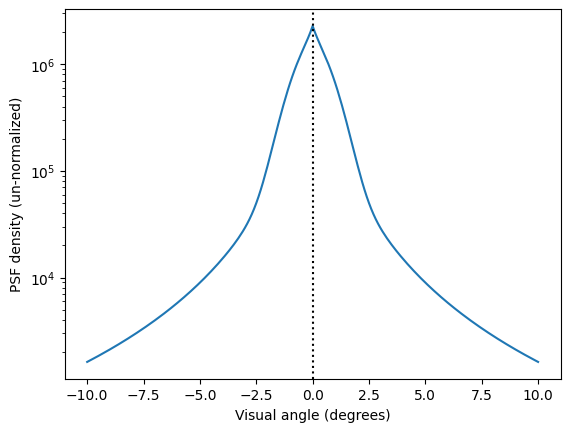

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# From Equation (5) in
# Physically-Based Glare Effects for Digital Images (Spencer et al.)
def photopic_psf(theta):
    f0 = 2.61e6 * np.exp(-(theta/0.02)**2)
    f1 = 20.91 * (theta + 0.02)**(-3)
    f2 = 72.37 * (theta + 0.02)**(-2)
    return 0.384*f0 + 0.478*f1 + 0.138*f2

thetas = np.linspace(-10, 10, 201)
psf_output = photopic_psf(np.pi/180 * np.abs(thetas))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Visual angle (degrees)")
ax.set_ylabel("PSF density (un-normalized)")
ax.set_yscale("log")
ax.plot(thetas, psf_output)
ylim = ax.get_ylim()
ax.vlines([0], ymin=ylim[0], ymax=ylim[1], colors="black", linestyles="dotted")
ax.set_ylim(ylim)

/tmp/ipykernel_965/2900568328.py:10: RuntimeWarning: divide by zero encountered in power
  return amp * np.exp(-np.abs(x/scale)**pow)


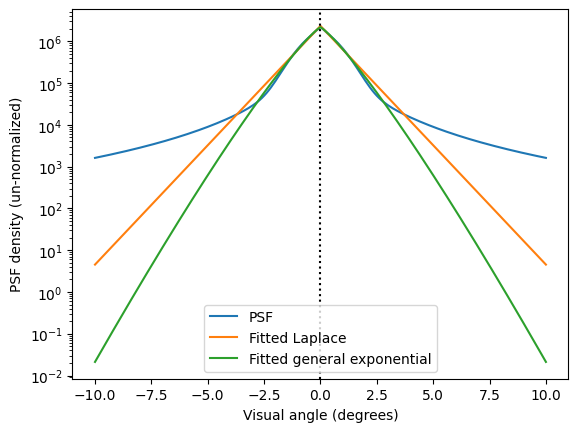

In [2]:
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit

def fit_pdf(pdf_func):
    def fit_func(x, amp, scale):
        return amp * pdf_func(x, scale=scale)
    return fit_func

def fit_exponential(x, amp, scale, pow):
    return amp * np.exp(-np.abs(x/scale)**pow)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Visual angle (degrees)")
ax.set_ylabel("PSF density (un-normalized)")
ax.set_yscale("log")
ax.plot(thetas, psf_output, label="PSF")
for name, fit_func, p0 in [
    # ("Gaussian", fit_pdf(norm.pdf), [2.61e6, 0.01]),
    ("Laplace", fit_pdf(laplace.pdf), [2.61e6, 0.01]),
    ("general exponential", fit_exponential, [2.61e6, 0.01, 0.5])
]:
    params, pcov = curve_fit(fit_func, thetas, psf_output, p0=p0)
    output = fit_func(thetas, *params)
    ax.plot(thetas, output, label=f"Fitted {name}")
ylim = ax.get_ylim()
ax.vlines([0], ymin=ylim[0], ymax=ylim[1], colors="black", linestyles="dotted")
ax.set_ylim(ylim)
ax.legend()

In [3]:
# Check normalization

from scipy.integrate import quad

norm_factor = 2 * np.pi * quad(photopic_psf, 0, np.inf)[0]
print(norm_factor)

193253.93781553046


In [4]:
from typing import Callable

from scipy.ndimage import convolve
from scipy.signal import fftconvolve

def apply_bloom(
    L: np.ndarray,
    image_fov_degrees: float = 72,
    mean_contrast_threshold: float = 100,
    psf: Callable[[np.ndarray], np.ndarray] = photopic_psf,
    kernel_fov_degrees: float = 20,
) -> np.ndarray:
    width = L.shape[1]
    kernel_width = round(width * kernel_fov_degrees / image_fov_degrees)
    center = kernel_width / 2
    X, Y = np.indices((kernel_width, kernel_width))
    deg_from_center = np.sqrt((X - center)**2 + (Y - center)**2) * image_fov_degrees / width
    psf_kernel = psf(deg_from_center)
    # Normalize PSF so it integrates to 1 over the kernel
    psf_kernel /= np.sum(psf_kernel)

    to_bloom = np.zeros_like(L)
    over_threshold = L > (mean_contrast_threshold * np.mean(L))
    to_bloom[over_threshold] = L[over_threshold]
    try:
        bloomed = convolve(to_bloom, psf_kernel, mode="nearest")
    except MemoryError:
        print("Direct convolution ran out of memory, using FFT instead")
        bloomed = fftconvolve(to_bloom, psf_kernel, mode="same")

    output = np.copy(L)
    output[over_threshold] = 0
    output += bloomed
    return output

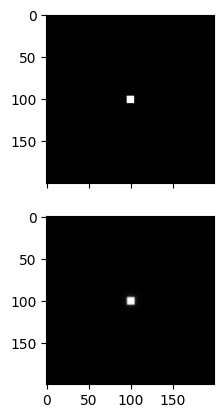

In [5]:
L = np.zeros((200, 200))
X, Y = np.indices(L.shape)
center = L.shape[0] / 2
L[((X - center)**2 < 20) & ((Y - center)**2 < 20)] = 1000


fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(L, cmap="Greys_r")
axs[1].imshow(apply_bloom(L, image_fov_degrees=45), cmap="Greys_r")

  0%|          | 0/4 [00:00<?, ?it/s]

Direct convolution ran out of memory, using FFT instead
Direct convolution ran out of memory, using FFT instead
Direct convolution ran out of memory, using FFT instead
Direct convolution ran out of memory, using FFT instead


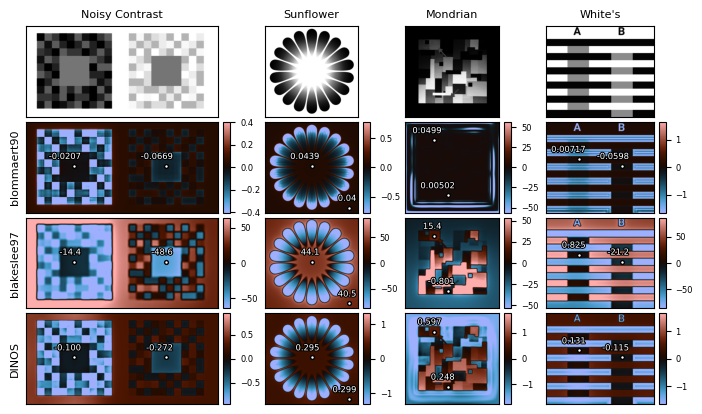

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.auto import tqdm

from src import dino

def file_to_luminance(file_path, white_nits=200):
    image = dino.read_image(file_path)
    L = dino.rgb_to_relative_luminance(image)
    L *= white_nits
    return L

IMAGE_POINTS_OF_INTEREST = [
    (
        "Noisy Contrast",
        "noisy_contrast.png",
        [(345, 315), (1005, 315)],
    ),
    (
        "Sunflower",
        "sunflower1.png",
        [(600, 615), (335, 315)],
    ),
    (
        "Mondrian",
        "mondrian1.png",
        [(210, 130), (305, 525)],
    ),
    (
        "White's",
        "whites.png",
        [(230, 265), (540, 315)],
    ),
]
MODELS = [
    ("blommaert90", dino.blommaert_brightness_model),
    ("blakeslee97", dino.blakeslee97_brightness_model),
    ("DINOS", dino.dinos_efficient),
]

fig = plt.figure()
nrows = 1 + len(MODELS)
ncols = len(IMAGE_POINTS_OF_INTEREST)
label_font_size = 8
number_font_size = 6
grid = ImageGrid(
    fig,
    (0, 0, 1, 1),
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.35, 0.05),
    cbar_location="right",
    cbar_mode="each",
    cbar_size=0.07,
    cbar_pad=0.05,
)

IMAGE_DIR = Path("images/egsr_illusions")
for row in tqdm(range(nrows)):
    for col, (title, image, pois) in enumerate(IMAGE_POINTS_OF_INTEREST):
        idx = row * ncols + col
        ax = grid[idx]
        cax = grid.cbar_axes[idx]
        image_path = IMAGE_DIR / image
        if row == 0:
            ax.set_title(title, fontsize=label_font_size)
            L = file_to_luminance(str(image_path))
            bloomed_img = apply_bloom(L, image_fov_degrees=60, mean_contrast_threshold=5)
            ax.imshow(bloomed_img, cmap="Greys_r", aspect="auto")
            cax.axis("off")
        else:
            name, model = MODELS[row-1]
            if col == 0:
                ax.set_ylabel(name, fontsize=label_font_size)
            
            L = file_to_luminance(str(image_path))
            bloomed_L = apply_bloom(L, image_fov_degrees=60, mean_contrast_threshold=5)
            brightness = model(L)
            vrange = max(np.abs(np.percentile(brightness, 90)), np.abs(np.percentile(brightness, 10)))
            norm = Normalize(vmin=-vrange, vmax=vrange, clip=True)
            im = ax.imshow(brightness, cmap="berlin", norm=norm)
            cbar = cax.colorbar(im, norm=norm)
            cax.tick_params(axis="y", labelsize=6)
            for px, py in pois:
                ax.scatter(px, py, marker=".", c="white", s=30, edgecolors="black")
                text = ax.text(
                    px+50,
                    py-50,
                    np.format_float_positional(brightness[py,px], precision=3, unique=False, fractional=False),
                    color="white",
                    fontsize=number_font_size,
                    horizontalalignment="right",
                )
                text.set_path_effects([withStroke(linewidth=1.5, foreground="k")])
    
for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig("_output/brightness_illusions_bloom.pdf", dpi=1200, bbox_inches="tight")